In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import h5py
import gzip
import json
import os
import tqdm

import warnings
warnings.filterwarnings('ignore')

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

# Setup dataset

In [2]:
with h5py.File("data/EpiGCN/train_test.hdf5", "r") as f:
    x_train = f["x_train"].value[..., 0]
    x_test = f["x_test"].value[..., 0]
    y_train = f["y_train"].value[..., 0]
    y_test = f["y_test"].value[..., 0]

In [3]:
# x_train = x_train[:, 0, :, :, :]
# # x_test = x_test[:, 0, :, :, :]
# y_train = y_train[:, 0, :, :, :]
# y_test = y_test[:, 0, :, :, :]

In [4]:
print("X train shape: ", x_train.shape)
print("X test shape: ", x_test.shape)
print("Y train shape: ", y_train.shape)
print("Y test shape: ", y_test.shape)

X train shape:  (312, 232, 232, 10)
X test shape:  (34, 232, 232, 10)
Y train shape:  (312, 232, 232, 1)
Y test shape:  (34, 232, 232, 1)


In [5]:
import torch
use_cuda = torch.cuda.is_available()
# device = torch.device("cuda:0" if use_cuda else "cpu")
device = torch.device("cpu")
print(device)

cpu


# Define Dataset

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
test_dataset = TensorDataset(torch.FloatTensor(x_test), torch.FloatTensor(y_test))

# Define Dataloader

In [7]:
# params = {"batch_size": 12, "shuffle": True, "num_workers": 4}

train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=0)

# Define the Model!

In [8]:
# import torch.nn as nn
# import torch.nn.functional as F


# class BaselineLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers):
#         super(BaselineLSTM, self).__init__()
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(
#             input_size=input_size,
#             hidden_size=hidden_size,
#             batch_first=True,
#             num_layers=num_layers,
#         )
#         self.linear_layers = nn.Sequential(
#             nn.Linear(hidden_size * num_layers, (hidden_size * num_layers * 2)),
#             nn.LeakyReLU(),
#             nn.Linear((hidden_size * num_layers * 2), input_size)
#         )

#     def forward(self, lstm_input):
#         """
#         :lstm_input: (b, 232, 232, 10)
#         """
#         #         print(lstm_input.size())
#         b, n_countries, n_countries, seq_len = lstm_input.size()
#         lstm_input = lstm_input.permute(0, 3, 1, 2)
#         _, (hn, __) = self.lstm(lstm_input.contiguous().view(b, seq_len, -1))
#         hn = hn.permute(1, 0, 2)
#         return self.linear_layers(hn.reshape(b, -1)).view(b, n_countries, n_countries, 1)

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class BaselineLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(BaselineLSTM, self).__init__()
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers,
        )
        self.linear = nn.Linear(hidden_size * num_layers, input_size)

    def forward(self, lstm_input):
        """
        :lstm_input: (b, 232, 232, 10)
        """
        #         print(lstm_input.size())
        b, n_countries, n_countries, seq_len = lstm_input.size()
        lstm_input = lstm_input.permute(0, 3, 1, 2)
        _, (hn, __) = self.lstm(lstm_input.contiguous().view(b, seq_len, -1))
        hn = hn.permute(1, 0, 2)
        return self.linear(hn.reshape(b, -1)).view(b, n_countries, n_countries, 1)

In [ ]:
# params = {
#     "lr": 0.001,
#     "input_size": 232 * 232,
#     "hidden_size": 1024,
#     "num_rnn_layers": 30,
# }

# params_str = ",".join(["{}={}".format(k, v) for k, v in params.items()])

# model = BaselineLSTM(
#     input_size=params["input_size"],
#     hidden_size=params["hidden_size"],
#     num_layers=params["num_layers"],
# )
# optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, patience=3, factor=0.5
# )

# mse = torch.nn.MSELoss()
# mae = torch.nn.L1Loss()


# class ModelSupervisor:
#     def __init__(
#         self,
#         input_size,
#         hidden_size,
#         num_rnn_layers,
#         lr_scheduler_patience=3,
#         lr_scheduler_decay_factor=0.5,
#     ):
#         self.model = BaselineLSTM(
#             input_size=params["input_size"],
#             hidden_size=params["hidden_size"],
#             num_layers=params["num_rnn_layers"],
#         )

#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=params["lr"])
#         self.mae = torch.nn.L1Loss()
#         self.mse = torch.nn.MSELoss()
#         self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#             self.optimizer, patience=3, factor=0.5
#         )

#     def train(self, dataloader):
#         for train_x, train_y in train_dataloader:
#             self.model = self.model.train()
#             optimizer.zero_grad()
#             logits = model(train_x)
#             loss = mae(logits, train_y)
#             loss.backward()
#             optimizer.step()
#             del loss
#             del logits

# Ignite!

In [ ]:
# params = {"lr": 0.001, "input_size": 232 * 232, "hidden_size": 1024, "num_layers": 10}

# params_str = ",".join(["{}={}".format(k, v) for k, v in params.items()])

# model = BaselineLSTM(
#     input_size=params["input_size"],
#     hidden_size=params["hidden_size"],
#     num_layers=params["num_layers"],
# )

In [9]:
params = {"lr": 0.001, "input_size": 232 * 232, "hidden_size": 1024, "num_layers": 10}

params_str = ",".join(["{}={}".format(k, v) for k, v in params.items()])

model = BaselineLSTM(
    input_size=params["input_size"],
    hidden_size=params["hidden_size"],
    num_layers=params["num_layers"],
)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import ModelCheckpoint
from ignite.metrics import Loss
from ignite.contrib.handlers.tensorboard_logger import *
import wandb
wandb.init(sync_tensorboard=True, name='country-level-10-layers-retry')

params = {"lr": 0.001, "input_size": 232 * 232, "hidden_size": 1024, "num_layers": 10}

params_str = ",".join(["{}={}".format(k, v) for k, v in params.items()])

wandb.config.initial_lr = params['lr']
wandb.config.input_size = params['input_size']
wandb.config.hidden_size = params['hidden_size']
wandb.config.num_layers = params['num_layers']
wandb.config.param_str = params_str

model = BaselineLSTM(
    input_size=params["input_size"],
    hidden_size=params["hidden_size"],
    num_layers=params["num_layers"],
)
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

mse = torch.nn.MSELoss()
mae = torch.nn.L1Loss()

tb_logger = TensorboardLogger(
    log_dir="experiments/tb_logs/runs/country_level_shuffle_{}".format(params_str)
)

trainer = create_supervised_trainer(model, optimizer, mae, device=device)

metrics = {"mae": Loss(mae), "mse": Loss(mse)}

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
validation_evaluator = create_supervised_evaluator(
    model, metrics=metrics, device=device
)


def score_function(trainer):
    validation_evaluator.run(test_dataloader)
    metrics = validation_evaluator.state.metrics
    mae = metrics["mae"]
    return -mae


checkpointer = ModelCheckpoint(
    "model_checkpoints",
    "country_level-" + params_str,
    score_function=score_function,
    score_name="mae",
    n_saved=1,
    create_dir=True,
    save_as_state_dict=True,
    require_empty=False,
)

trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {"epi": model})

tb_logger.attach(
    trainer,
    log_handler=OutputHandler(
        tag="training", output_transform=lambda loss: {"loss": loss}
    ),
    event_name=Events.ITERATION_COMPLETED,
)

tb_logger.attach(
    train_evaluator,
    log_handler=OutputHandler(
        tag="training",
        metric_names=["mae", "mse"],
        global_step_transform=global_step_from_engine(trainer),
    ),
    event_name=Events.EPOCH_COMPLETED,
)

tb_logger.attach(
    validation_evaluator,
    log_handler=OutputHandler(
        tag="validation",
        metric_names=["mae", "mse"],
        global_step_transform=global_step_from_engine(trainer),
    ),
    event_name=Events.EPOCH_COMPLETED,
)

# Attach the logger to the trainer to log optimizer's parameters, e.g. learning rate at each iteration
tb_logger.attach(
    trainer,
    log_handler=OptimizerParamsHandler(optimizer),
    event_name=Events.ITERATION_STARTED,
)

# Attach the logger to the trainer to log model's weights norm after each iteration
tb_logger.attach(
    trainer,
    log_handler=WeightsScalarHandler(model),
    event_name=Events.ITERATION_COMPLETED,
)

# Attach the logger to the trainer to log model's weights as a histogram after each epoch
tb_logger.attach(
    trainer, log_handler=WeightsHistHandler(model), event_name=Events.EPOCH_COMPLETED
)

# Attach the logger to the trainer to log model's gradients norm after each iteration
tb_logger.attach(
    trainer,
    log_handler=GradsScalarHandler(model),
    event_name=Events.ITERATION_COMPLETED,
)

# Attach the logger to the trainer to log model's gradients as a histogram after each epoch
tb_logger.attach(
    trainer, log_handler=GradsHistHandler(model), event_name=Events.EPOCH_COMPLETED
)


@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(trainer):
    logger.info(
        "Epoch[{}] Loss: {:.7f}".format(trainer.state.epoch, trainer.state.output)
    )


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_dataloader)
    metrics = train_evaluator.state.metrics
    logger.info(
        "Training Results - Epoch: {} MSE: {:.7f} MAE: {:.7f}".format(
            trainer.state.epoch, metrics["mse"], metrics["mae"]
        )
    )


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    validation_evaluator.run(test_dataloader)
    metrics = validation_evaluator.state.metrics
    logger.info(
        "Validation Results - Epoch: {} MSE: {:.7f} MAE: {:.7f}".format(
            trainer.state.epoch, metrics["mse"], metrics["mae"]
        )
    )
    lr_scheduler.step(metrics["mae"])


trainer.run(train_dataloader, max_epochs=100)
# We need to close the logger with we are done
tb_logger.close()

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: WARNING Not logging key "weights/lstm/weight_ih_l0".  Histograms must have fewer than 512 bins
wandb: WARNING Not logging key "weights/lstm/weight_hh_l0".  Histograms must have fewer than 512 bins
wandb: WARNING Not logging key "weights/lstm/bias_ih_l0".  Histograms must have fewer than 512 bins
wandb: WARNING Not logging key "weights/lstm/bias_hh_l0".  Histograms must have fewer than 512 bins
wandb: WARNING Not logging key "weights/lstm/weight_ih_l1".  Histograms must have fewer than 512 bins
wandb: WARNING Not logging key "weights/lstm/weight_hh_l1".  Histograms must have fewer than 512 bins
wandb: WARNING Not logging key "weights/lstm/bias_ih_l1".  Histograms must have fewer than 512 bins
wandb: WARNING Not logging key "weights/lstm/bias_hh_l1".  Histograms must have fewer than 512 bins
wandb: WARNING Not logging key "weights/lstm/weight_ih_l2".  Hi

In [10]:
model

BaselineLSTM(
  (lstm): LSTM(53824, 1024, num_layers=10, batch_first=True)
  (linear): Linear(in_features=10240, out_features=53824, bias=True)
)

In [12]:
import torch

model.load_state_dict(
    torch.load(
        "model_checkpoints/country_level-lr=0.001,input_size=53824,hidden_size=1024,num_layers=10_epi_71_mae=0.01335459.pth"
    )
)
# model = model.to(device)

<All keys matched successfully>

In [13]:
import joblib

scaler = joblib.load("data/EpiGCN/standard_scaler.pkl")
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [14]:
def get_scaled_output(y):
    shape = y.shape
    y = y.reshape(-1)
    mean = scaler.mean_[0]
    scale = scaler.scale_[0]
    return (scale * y + mean).reshape(*shape)

In [15]:
predictions, truth = [], []
with torch.no_grad():
    for batch_x, batch_y in test_dataloader:
        logits = model(batch_x.to(device))
        predictions.append(get_scaled_output(logits.cpu().numpy()))
        truth.append(get_scaled_output(batch_y.cpu().numpy()))
predictions = np.concatenate(predictions)
truth = np.concatenate(truth)

In [16]:
truth.shape

(34, 232, 232, 1)

# Test Viz

In [28]:
# fig, ax = plt.subplots(figsize=(20, 6))
# ax.set_title("Incidence", fontsize=20)
# # ax.set_ylabel("Latent", fontsize=20)
# ax.set_xlabel("Days", fontsize=20)
# ax.plot(
#     np.expm1(predictions).mean(axis=(2))[:, 10, 0], label="Prediction",
# )
# ax.plot(np.expm1(truth).mean(axis=(2))[:, 10, 0], label="Truth")
# ax.legend()

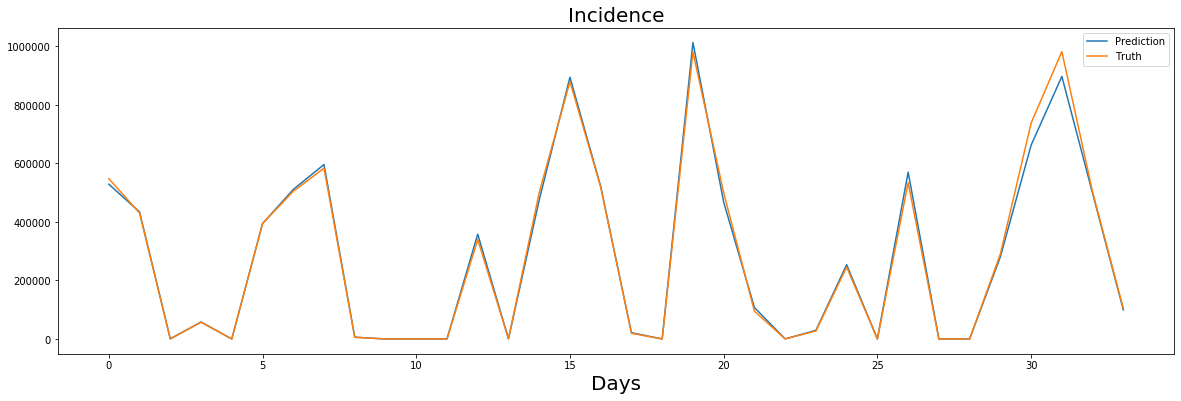

In [24]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title("Incidence", fontsize=20)
# ax.set_ylabel("Latent", fontsize=20)
ax.set_xlabel("Days", fontsize=20)
ax.plot(
    np.expm1(predictions).mean(axis=(1, 2))[:, 0], label="Prediction",
)
ax.plot(np.expm1(truth).mean(axis=(1, 2))[:, 0], label="Truth")
ax.legend()

The above plot is mean count across all countries (y-axis) vs time (x-axis)

In [29]:
from ipywidgets import interact


@interact
def plot(country_id=list(range(232))):
    fig, ax = plt.subplots(2, 1, figsize=(20, 12))
    ax[0].set_title("Test Truth: Incidence", fontsize=20)
    ax[1].set_title("Test Predictions: Incidence", fontsize=20)
    ax[0].set_ylabel("Infectious_SympT", fontsize=20)
    ax[1].set_ylabel("Infectious_SympT", fontsize=20)
    # ax[0].set_xlabel("Days", fontsize=20)
    for i in range(truth.shape[1]):
        ax[0].plot(np.expm1(truth[country_id, :, i, 0]))
        ax[1].plot(np.expm1(predictions[country_id, :, i, 0]))

interactive(children=(Dropdown(description='country_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

In [19]:
np.abs(truth - predictions).mean()

0.061268143

In [20]:
np.square(np.expm1(truth) - np.expm1(predictions)).mean()

229465960000.0

In [21]:
np.abs(np.expm1(truth) - np.expm1(predictions)).mean()

15164.935

## Train viz

In [ ]:
x_train = get_scaled_output(x_train)
y_train = get_scaled_output(y_train)

In [ ]:
x_train.shape

In [ ]:
from ipywidgets import interact

@interact
def plot(country_id=list(range(232))):
    fig, ax = plt.subplots(2, 1, figsize=(20, 12))
    ax[0].set_title("Training Data X: Incidence", fontsize=20)
    ax[1].set_title("Training Data Y: Incidence", fontsize=20)
    ax[0].set_ylabel("Infectious_SympT", fontsize=20)
#     ax[0].set_xlabel("Days", fontsize=20)
    for i in range(truth.shape[1]):
        ax[0].plot(np.expm1(x_train[country_id, :, i, 0]))
        ax[1].plot(np.expm1(y_train[country_id, :, i, 0]))

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=False, num_workers=12)

In [ ]:
train_predictions, train_truth = [], []
with torch.no_grad():
    for batch_x, batch_y in train_dataloader:
        logits = model(batch_x.to(device))
        train_predictions.append(get_scaled_output(logits.cpu()))
        train_truth.append(get_scaled_output(batch_y.cpu()))
train_predictions = np.concatenate(train_predictions)
train_truth = np.concatenate(train_truth)

In [ ]:
from ipywidgets import interact

@interact
def plot(country_id=list(range(232))):
    fig, ax = plt.subplots(2, 1, figsize=(20, 12))
    ax[0].set_title("Training Truth: Incidence", fontsize=20)
    ax[1].set_title("Training Predictions: Incidence", fontsize=20)
    ax[0].set_ylabel("Infectious_SympT", fontsize=20)
#     ax[0].set_xlabel("Days", fontsize=20)
    for i in range(truth.shape[1]):
        ax[0].plot(np.expm1(train_truth[:, country_id, i, 0]))
        ax[1].plot(np.expm1(train_predictions[:, country_id, i, 0]))